# GraphWave aglorithm on a barbell graph

This demo features the algorithm GraphWave published in "Learning Structural Node Embeddings via Diffusion Wavelets" [https://arxiv.org/pdf/1710.10321.pdf]. GraphWave embeds the structural features of a node in a dense embeddings. We will demonstrate the use of GraphWave on a barbell graph demonstrating that structurally equivalent nodes have similar embeddings.

First, we load the required libraries.

In [1]:
import networkx as nx
from stellargraph.mapper import GraphWaveGenerator
from stellargraph import StellarGraph
from sklearn.decomposition import PCA
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse.linalg import eigs
import tensorflow as tf
from tensorflow.keras import backend as K

### Graph construction

Next, we construct the barbell graph, shown below. It consists of 2 fully connected graphs (at the 'ends' of the graph) connected by a chain of nodes. All nodes in the fully connected ends are structurally equivalent, as are the opposite nodes in the chain. A good strucutural embedding algorithm should embed equivalent nodes close togethed in the embedding space.

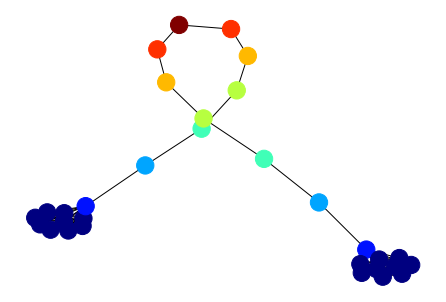

In [2]:
m1 = 10
m2 = 11
gnx = nx.barbell_graph(m1=m1, m2=m2)

classes = [0,] * len(gnx.nodes)
# number of nodes with a non-zero class (the path, plus the nodes it connects to on either end)
nonzero = m2 + 2
# count up to the halfway point (rounded up)
first = range(1, (nonzero + 1) // 2 + 1)
# and down for the rest
second = reversed(range(1, nonzero - len(first) + 1))
classes[m1 - 1:(m1 + m2) + 1] = list(first) + list(second)

nx.draw(gnx, node_color=classes, cmap="jet")

### GraphWave embedding calculation

Now, we're ready to calculate the GraphWave embeddings. We need to specify some information about how to sample the characteristic function: 

- an iterable of wavelet `scales` to use. This is a graph dependent hyperparameter. Experiment with different values.
- the number `num_eigenvecs` of eigenvectors to use. A larger number of eigenvectors will yield better results but is more computationally expensive. `num_eigenvecs=None` will automatically estimate and use a number of eigenvectors that is a reasonable approximation to the full set of eigenvectors.
- the `sample_points` at which to sample the characteristic function. This should be of the form `sample_points=np.linspace(0, max_val, number_of_samples)`. The best value depends on the graph.

In [19]:
G = StellarGraph(gnx)
sample_points = np.linspace(0, 100, 50).astype(np.float32)

generator = GraphWaveGenerator(G, scales=[5, 10], num_eigenvecs=None,)

embeddings_dataset = generator.flow(
    node_ids=G.nodes(), sample_points=sample_points, batch_size=1, repeat=False
)

embeddings = [x.numpy() for x in embeddings_dataset]

/Users/kieranricardo/PycharmProjects/current-stellargraph/stellargraph/stellargraph/core/experimental.py:88: ExperimentalWarning: GraphWaveGenerator is experimental: lacks unit tests, and the time complexity could be reduced using Chebyshev polynomials. (see: https://github.com/stellargraph/stellargraph/issues/815, https://github.com/stellargraph/stellargraph/issues/853). It may be difficult to use and may have major changes at any time.
  warnings.warn(direct_msg, ExperimentalWarning)
/Users/kieranricardo/anaconda3/envs/tf2-stellar/lib/python3.6/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


### Visualation

The nodes are coloured by their structural role, e.g. in the connected component, 1st node in the chain, 2nd node in the chain etc. We can see that all nodes of the same colour completely overlap in this visualation, indicating that structurally equivalent nodes are very close in the embedding space.

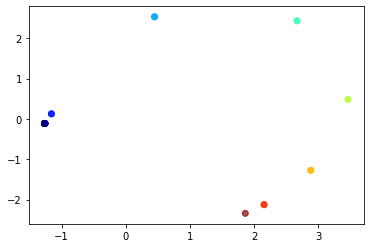

In [20]:
trans_emb = PCA(n_components=2).fit_transform(np.vstack(embeddings))

plt.scatter(
    trans_emb[:, 0], trans_emb[:, 1], c=classes, cmap="jet", alpha=0.7,
)
plt.show()